# Importing Library

In [362]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import VotingClassifier
from tqdm import tqdm
from itertools import combinations, product
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.ensemble import VotingClassifier
from tqdm import tqdm
from itertools import combinations, product
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer, TfidfVectorizer)
# from sklearn.feature_selection import SequentialFeatureSelector

from pycaret.classification import * 


import nltk
from nltk import word_tokenize, ngrams
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
import spacy

from sklearn.cluster import (KMeans, AffinityPropagation, AgglomerativeClustering)
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import (PCA, TruncatedSVD)
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.metrics import (silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score)
from sklearn.model_selection import train_test_split
from Levenshtein import distance
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

In [363]:
snow=nltk.stem.SnowballStemmer('english')

stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])


# Reading Data

In [364]:
df22 = pd.read_csv('data.csv')
df22.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [365]:
df = pd.read_csv('data.csv', usecols = ['job_title', 'location', 'connection'])

In [366]:
df.head()

,job_title,location,connection
0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85
1,Native English Teacher at EPIK (English Progra...,Kanada,500+
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44
3,People Development Coordinator at Ryan,"Denton, Texas",500+
4,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+


In [367]:
df.shape

(104, 3)

In [368]:
df[df['location'] == 'Kanada']['job_title'].iloc[3]

'Native English Teacher at EPIK (English Program in Korea)'

# Fixing Duplicates and spellings

There were several data items repeated in giveb dataset. Below code identifies this duplicate items. We will remove this duplicate items so we can have clened dataset.

In [369]:
duplicate_count = df.groupby(df.columns.to_list(), as_index = False).size().sort_values(by = 'size', ascending = False)

In [370]:
duplicate_count.head(20)

,job_title,location,connection,size
0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,7
49,Student at Humber College and Aspiring Human R...,Kanada,61,7
37,People Development Coordinator at Ryan,"Denton, Texas",500+,6
8,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,6
35,Native English Teacher at EPIK (English Progra...,Kanada,500+,5
20,HR Senior Specialist,San Francisco Bay Area,500+,5
11,Aspiring Human Resources Specialist,Greater New York City Area,1,5
42,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,4
2,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,4
21,Human Resources Coordinator at InterContinenta...,"Atlanta, Georgia",500+,4


In [371]:
df_clean = df.drop_duplicates()
df_clean.shape
# df_clean = df.copy()

(53, 3)

After cleaning dataset, we can see that we have total of 53 items. It is a small dataset but we can still use it.

# Word Count and Character Count

We can generate word count and character count from Job title column.It was intersting to see that there is one job title with one word only. However, all job title were valid and clean.

In [372]:
df_clean['word_count'] = df_clean['job_title'].apply(lambda x : len(str(x).split()))
df_clean['character_count'] = df_clean['job_title'].apply(lambda x : len(str(x)))

In [373]:
df_clean[['word_count', 'character_count']].describe()

,word_count,character_count
count,53.000000,53.000000
mean,7.754717,57.566038
std,3.931655,25.790957
min,1.000000,7.000000
25%,5.000000,37.000000
50%,7.000000,53.000000
75%,9.000000,69.000000
max,20.000000,117.000000


In [374]:
df_clean[df_clean['word_count'] < 4]

,job_title,location,connection,word_count,character_count
7,HR Senior Specialist,San Francisco Bay Area,500+,3,20
73,Human Resources Professional,Greater Boston Area,16,3,28
97,Student,"Houston, Texas Area",4,1,7


We will develop a function which will clean text. It will remove any unnecessary characters. Also, it will make textlower case.

In [375]:
def cleaning(s):
    s = str(s)
    s = s.lower()
#     s = re.sub('\s\W',' ',s)
#     s = re.sub('\W,\s',' ',s)
#     s = re.sub(r'[^\w]', ' ', s)
#     s = re.sub("\d+", "", s)
#     s = re.sub('\s+',' ',s)
    s = re.sub('[!@#$_\?\(\).\|]', '', s)
#     s = s.replace("co","")
#     s = s.replace("https","")
#     s = s.replace(",","")
#     s = s.replace("[\w*"," ")
#     s = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", s)
#     s = re.sub(r"what's", "what is ", s)
    s = re.sub(r"\'s", " ", s)
#     s = re.sub(r"\'ve", " have ", s)
#     s = re.sub(r"can't", "cannot ", s)
#     s = re.sub(r"n't", " not ", s)
#     s = re.sub(r"i'm", "i am ", s)
#     s = re.sub(r"\'re", " are ", s)
#     s = re.sub(r"\'d", " would ", s)
#     s = re.sub(r"\'ll", " will ", s)
    s = re.sub(r",", "", s)
#     s = re.sub(r"\.", " ", s)
#     s = re.sub(r"!", " ! ", s)
#     s = re.sub(r"\/", " ", s)
#     s = re.sub(r"\^", " ^ ", s)
#     s = re.sub(r"\+", " + ", s)
#     s = re.sub(r"\-", " - ", s)
#     s = re.sub(r"\=", " = ", s)
#     s = re.sub(r"'", " ", s)
#     s = re.sub(r"(\d+)(k)", r"\g<1>000", s)
#     s = re.sub(r":", " : ", s)
#     s = re.sub(r" e g ", " eg ", s)
#     s = re.sub(r" b g ", " bg ", s)
#     s = re.sub(r" u s ", " american ", s)
#     s = re.sub(r"\0s", "0", s)
#     s = re.sub(r" 9 11 ", "911", s)
#     s = re.sub(r"e - mail", "email", s)
#     s = re.sub(r"j k", "jk", s)
#     s = re.sub(r"\s{2,}", " ", s)
#     s = re.sub(r"what's", "", s)
#     s = re.sub(r"\'s", " ", s)
#     s = re.sub(r"\'ve", " have ", s)
#     s = re.sub(r"can't", "cannot ", s)
#     s = re.sub(r"n't", " not ", s)
#     s = re.sub(r" m ", " am ", s)
#     s = re.sub(r"\'re", " are ", s)
#     s = re.sub(r"\'d", " would ", s)
#     s = re.sub(r"60k", " 60000 ", s)
#     s = re.sub(r"\0s", "0", s)
#     s = re.sub(r"e-mail", "email", s)
#     s = re.sub(r"\s{2,}", " ", s)
#     s = re.sub(r"quikly", "quickly", s)
#     s = re.sub(r" usa ", " america ", s)
#     s = re.sub(r" uk ", " england ", s)
#     s = re.sub(r"imrovement", "improvement", s)
#     s = re.sub(r"intially", "initially", s)
#     s = re.sub(r" dms ", "direct messages ", s)  
#     s = re.sub(r"demonitization", "demonetization", s) 
#     s = re.sub(r"actived", "active", s)
#     s = re.sub(r"kms", " kilometers ", s)
#     s = re.sub(r" cs ", " computer science ", s) 
#     s = re.sub(r" upvotes ", " up votes ", s)
#     s = re.sub(r" iPhone ", " phone ", s)
#     s = re.sub(r"\0rs ", " rs ", s) 
#     s = re.sub(r"calender", "calendar", s)
#     s = re.sub(r"ios", "operating system", s)
#     s = re.sub(r"gps", "GPS", s)
#     s = re.sub(r"gst", "GST", s)
#     s = re.sub(r"programing", "programming", s)
#     s = re.sub(r"bestfriend", "best friend", s)
#     s = re.sub(r"III", "3", s) 
#     s = re.sub(r"the us", "america", s)
    return s
df_clean['job_title'] = [cleaning(s) for s in df_clean['job_title']]
df_clean['location'] = [cleaning(s) for s in df_clean['location']]
df_clean['location'] = df_clean['location'].replace(to_replace = ['kanada', 'türkiye', 'amerika birleşik devletleri'], 
                                            value = ['canada', 'turkey', 'united states america'], 
                                            regex = True)


In [376]:
df_clean.head()

,job_title,location,connection,word_count,character_count
0,2019 ct bauer college of business graduate mag...,houston texas,85,15,104
1,native english teacher at epik english program...,canada,500+,9,57
2,aspiring human resources professional,raleigh-durham north carolina area,44,4,37
3,people development coordinator at ryan,denton texas,500+,5,38
4,advisory board member at celal bayar university,i̇zmir turkey,500+,7,47


# Methodology

We wil use following methodology. 

1) We will stem or lemmatize both Job title and location columns.

2) We will vectorize both job title and location columns using Count Vectorizer (Method1) or (TfIdf Vectorizer).

3) We will calculate Levenshtein distnace and Eucladian distance from given keywords. (job title keyword and location keyword)

4) We will perform weighted fit on location and job title. 



# Stemmering / Unigram

We will use two methods which are popular in Natural language processing. First method is Stemmering. Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma.

Other method is lemmatization. Lemmatization considers the context and converts the word to its meaningful base form, which is called Lemma.

In [377]:
def get_unigram(question):
    return [ps.stem(word) for word in word_tokenize(question.lower()) if word not in stop_words]

In [378]:

df_clean['unigram_job_title'] = df_clean['job_title'].apply(lambda x : list(set(get_unigram(str(x)))))
df_clean['unigram_location'] = df_clean['location'].apply(lambda x : list(set(get_unigram(str(x)))))

In [379]:
df_clean.head()

,job_title,location,connection,word_count,character_count,unigram_job_title,unigram_location
0,2019 ct bauer college of business graduate mag...,houston texas,85,15,104,"[magna, colleg, aspir, busi, resourc, 2019, la...","[texa, houston]"
1,native english teacher at epik english program...,canada,500+,9,57,"[korea, english, epik, nativ, program, teacher]",[canada]
2,aspiring human resources professional,raleigh-durham north carolina area,44,4,37,"[profession, aspir, resourc, human]","[carolina, raleigh-durham, area, north]"
3,people development coordinator at ryan,denton texas,500+,5,38,"[ryan, coordin, peopl, develop]","[denton, texa]"
4,advisory board member at celal bayar university,i̇zmir turkey,500+,7,47,"[univers, celal, member, advisori, board, bayar]","[turkey, i̇zmir]"


In [380]:
df_clean['connection'] = df_clean['connection'].replace(to_replace = '500', value = 500, regex = True)


In [381]:
# df_clean['full_string'] = df_clean.apply(lambda x : ' '.join(x['unigram_job_title']) +' ' + ' '.join(x['unigram_location']), axis = 1)

In [382]:
df_clean.head()

,job_title,location,connection,word_count,character_count,unigram_job_title,unigram_location
0,2019 ct bauer college of business graduate mag...,houston texas,85,15,104,"[magna, colleg, aspir, busi, resourc, 2019, la...","[texa, houston]"
1,native english teacher at epik english program...,canada,500,9,57,"[korea, english, epik, nativ, program, teacher]",[canada]
2,aspiring human resources professional,raleigh-durham north carolina area,44,4,37,"[profession, aspir, resourc, human]","[carolina, raleigh-durham, area, north]"
3,people development coordinator at ryan,denton texas,500,5,38,"[ryan, coordin, peopl, develop]","[denton, texa]"
4,advisory board member at celal bayar university,i̇zmir turkey,500,7,47,"[univers, celal, member, advisori, board, bayar]","[turkey, i̇zmir]"


# Model Development

We will create two dataset. One for job title and one for location.

In [383]:
X_job = df_clean['job_title'].values
X_location = df_clean['location'].values
# X2 = ' '.join(X)
# X2 = [X2]

## Kmeans Clusters

We will just perform kmeans clusters to see how many clusters are possible using elbow method. This will help us to determine minumum clusters we need. Minimum number of clusters are calculated both for job title and location.

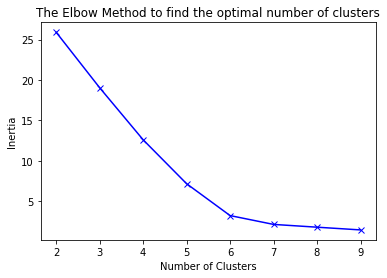

In [384]:
clusters = np.arange(2,10,1)
distortions = []

for c in clusters:
    Kmeans_pipeline = Pipeline([('vectorizer', CountVectorizer()),
                                ('pca', TruncatedSVD(n_components = 2)),
                           ('clustering', KMeans(c))                           
                           ])
    Kmeans_pipeline.fit(X_job)
    distortions.append(Kmeans_pipeline['clustering'].inertia_)
    
plt.plot(clusters, distortions, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method to find the optimal number of clusters')
plt.xticks(clusters)
plt.show()   

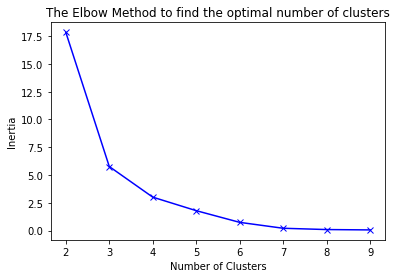

In [385]:
clusters = np.arange(2,10,1)
distortions = []

for c in clusters:
    Kmeans_pipeline = Pipeline([('vectorizer', CountVectorizer()),
                                ('pca', TruncatedSVD(n_components = 2)),
                           ('clustering', KMeans(c))                           
                           ])
    Kmeans_pipeline.fit(X_location)
    distortions.append(Kmeans_pipeline['clustering'].inertia_)
    
plt.plot(clusters, distortions, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method to find the optimal number of clusters')
plt.xticks(clusters)
plt.show()   

We can see using elbow method minimum clusters for job title is 6 and also for location it is 6.

For n_clusters = 2 The average silhouette_score is : 0.083235481275804
For n_clusters = 3 The average silhouette_score is : 0.025248490393319372
For n_clusters = 4 The average silhouette_score is : 0.0666994159030734
For n_clusters = 5 The average silhouette_score is : 0.03639905402791426
For n_clusters = 6 The average silhouette_score is : 0.03681660857583333
For n_clusters = 7 The average silhouette_score is : 0.00716582364665832
For n_clusters = 8 The average silhouette_score is : 0.03705280773735209
For n_clusters = 9 The average silhouette_score is : 0.043306775189410195
For n_clusters = 10 The average silhouette_score is : 0.03872803263388327
For n_clusters = 11 The average silhouette_score is : 0.04070873658972597
For n_clusters = 12 The average silhouette_score is : 0.04675225327126927
For n_clusters = 13 The average silhouette_score is : 0.046657216713078306
For n_clusters = 14 The average silhouette_score is : 0.036155817757543424
For n_clusters = 15 The average silhouette_sc

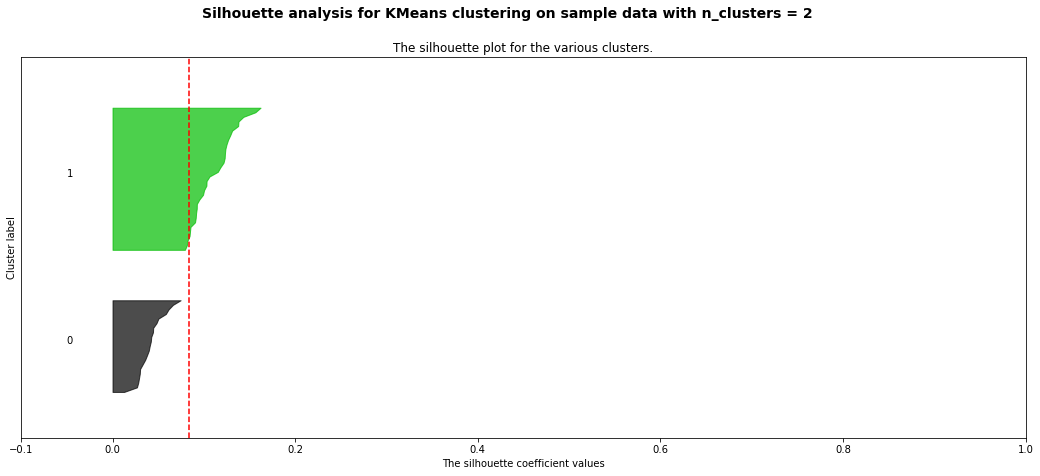

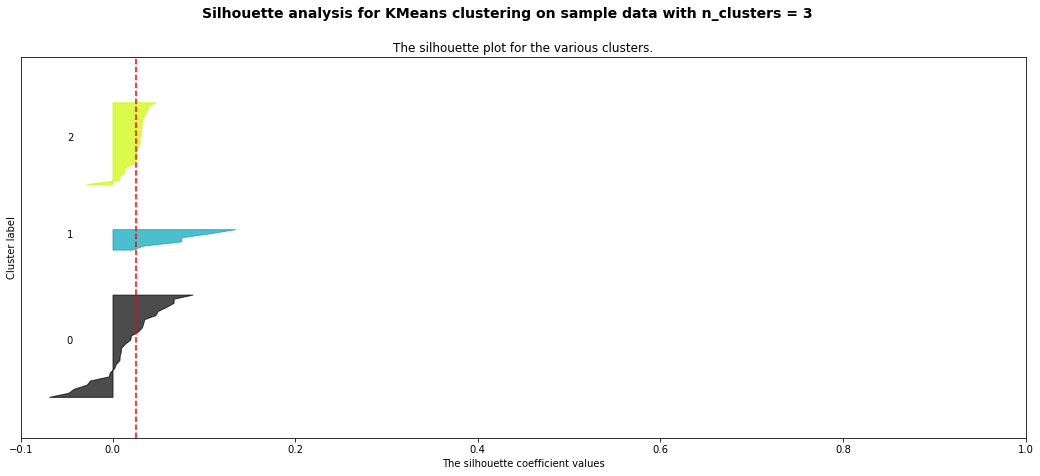

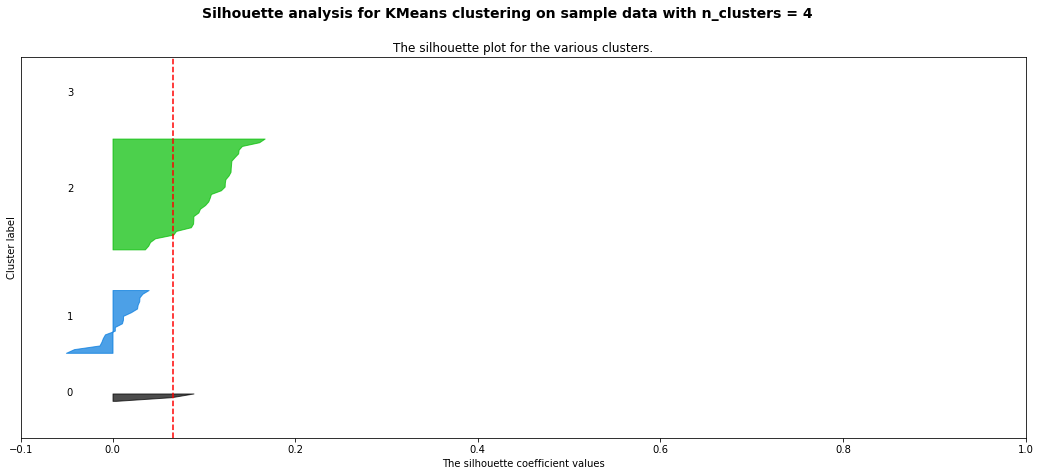

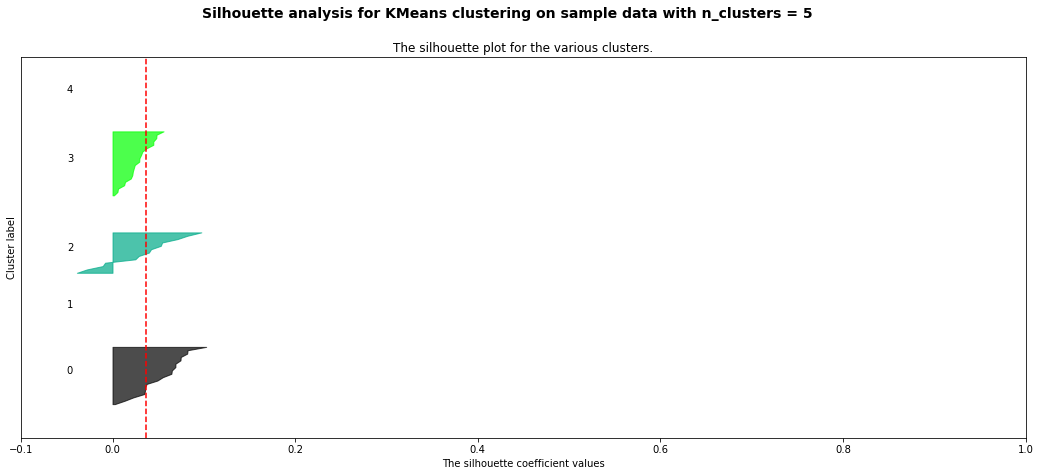

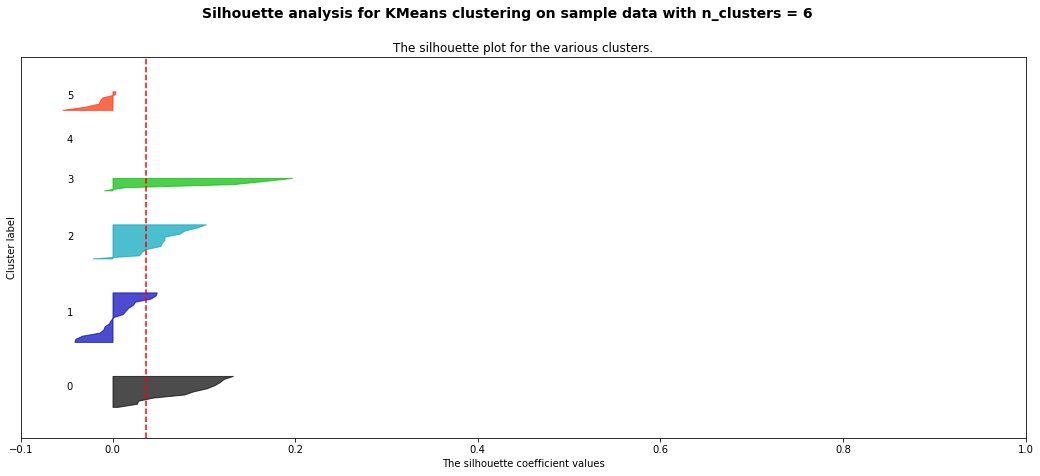

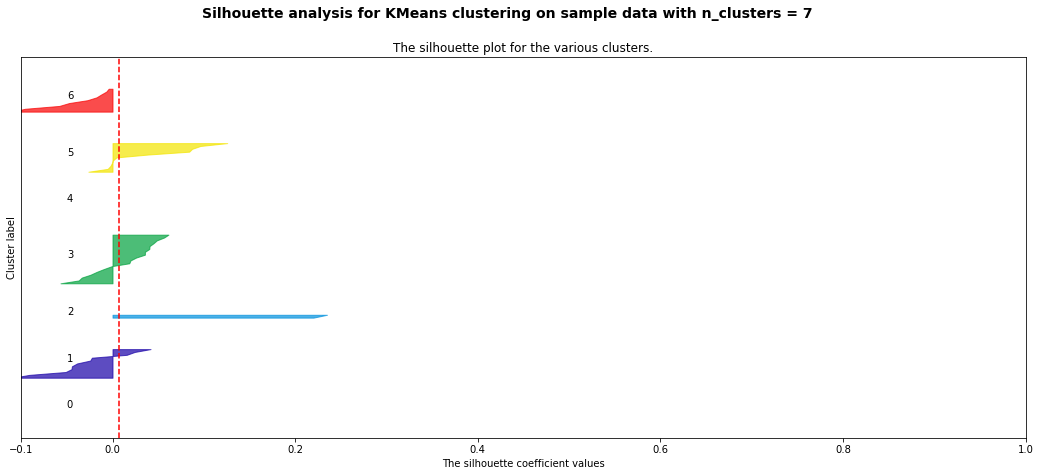

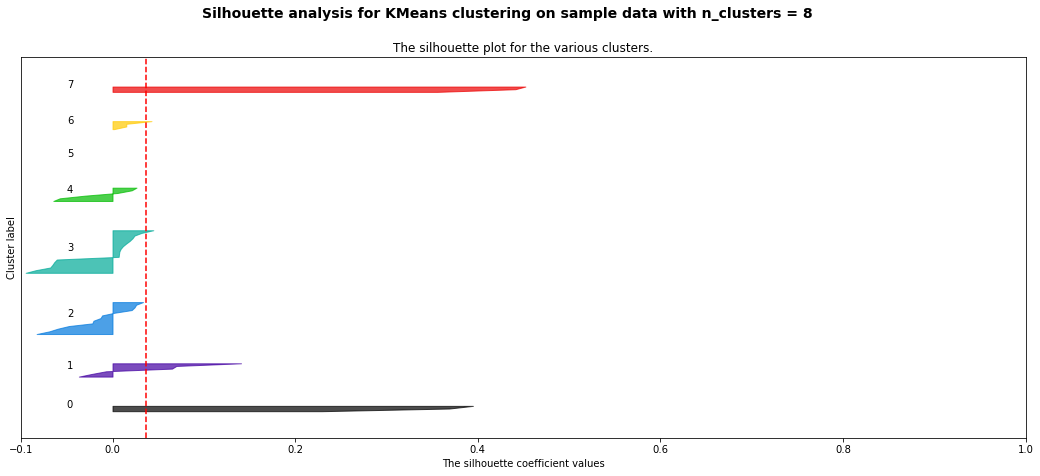

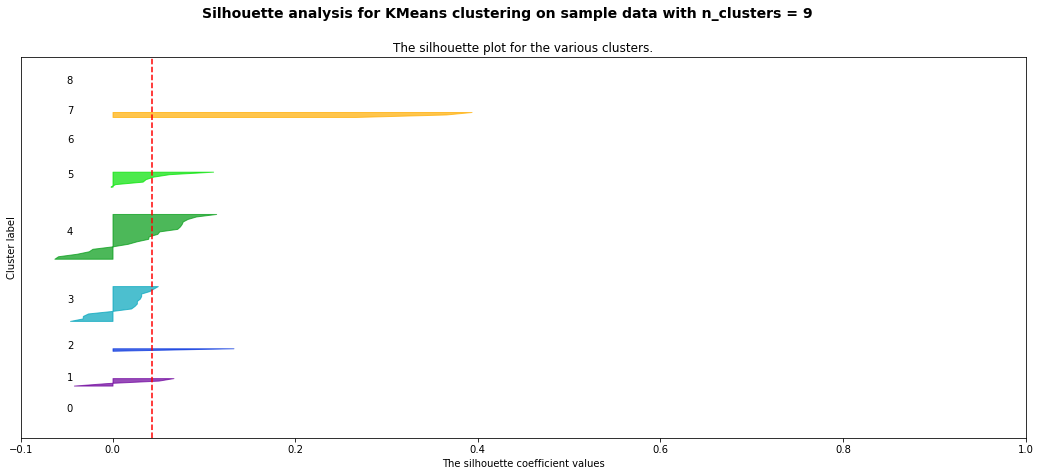

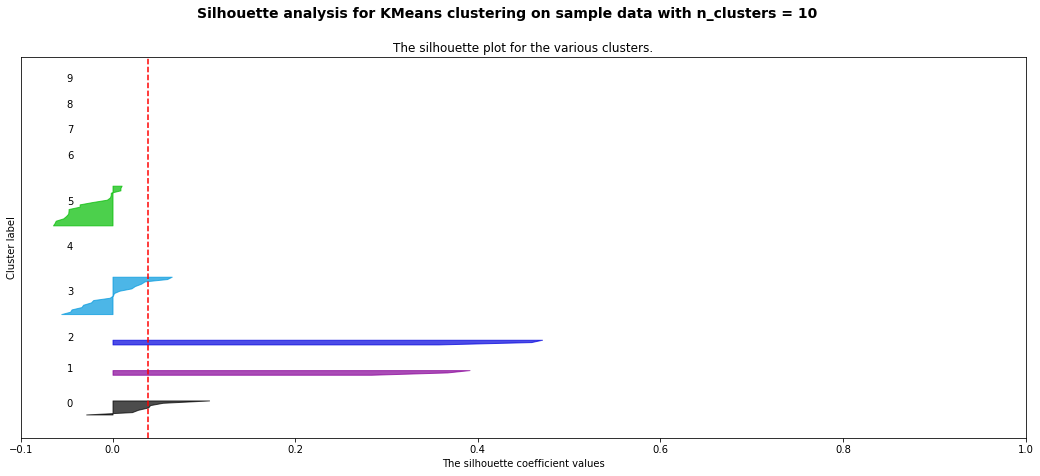

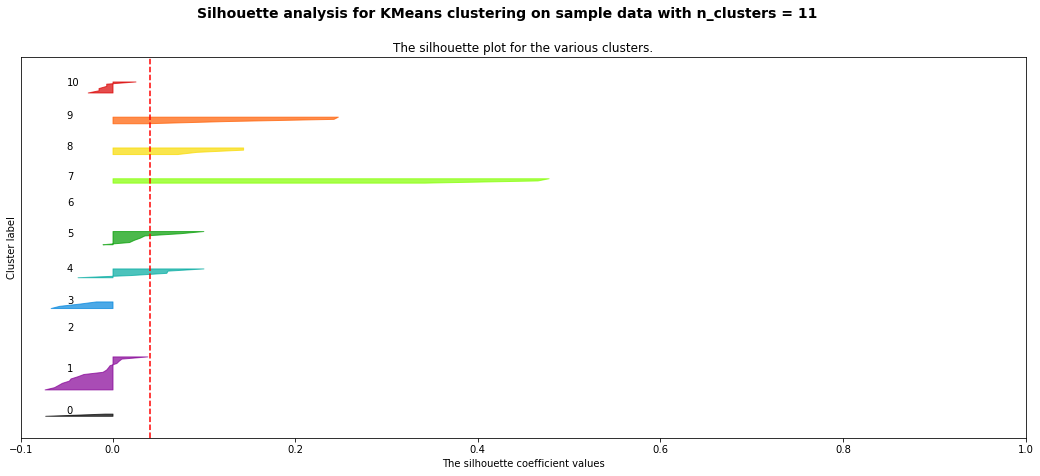

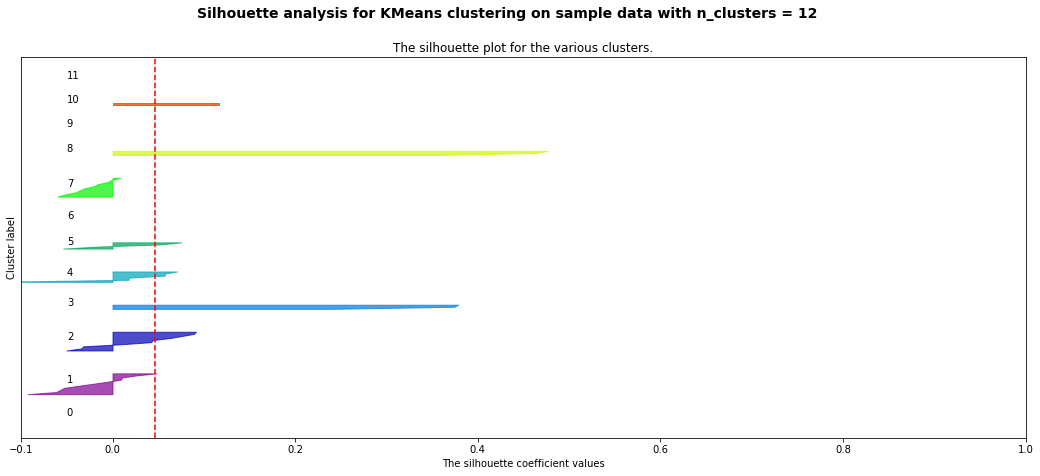

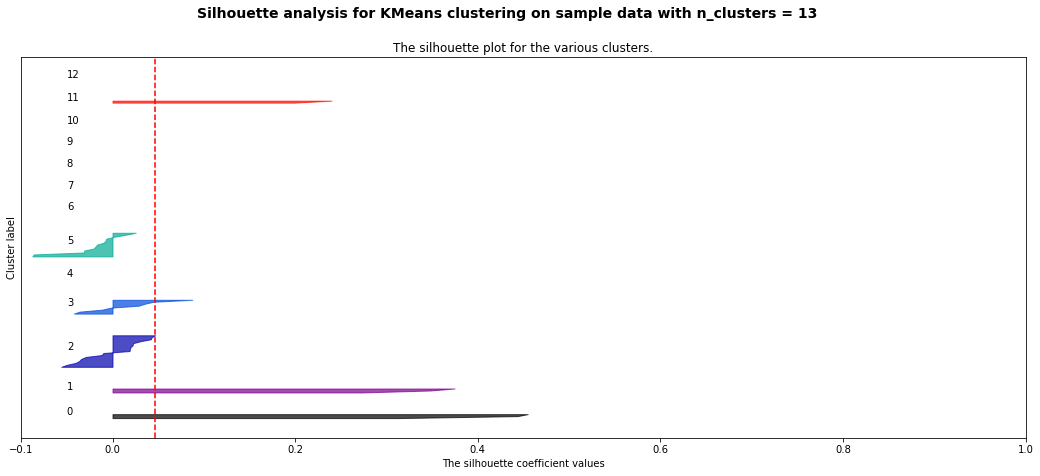

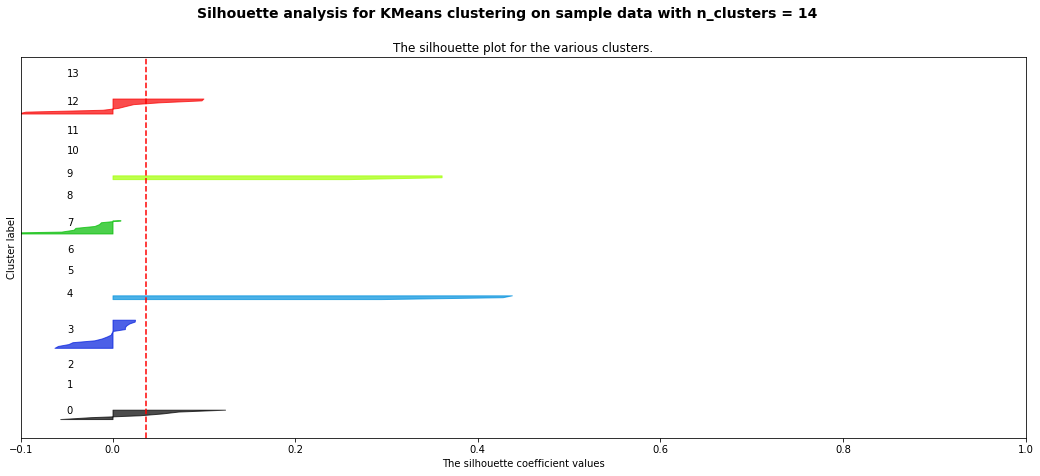

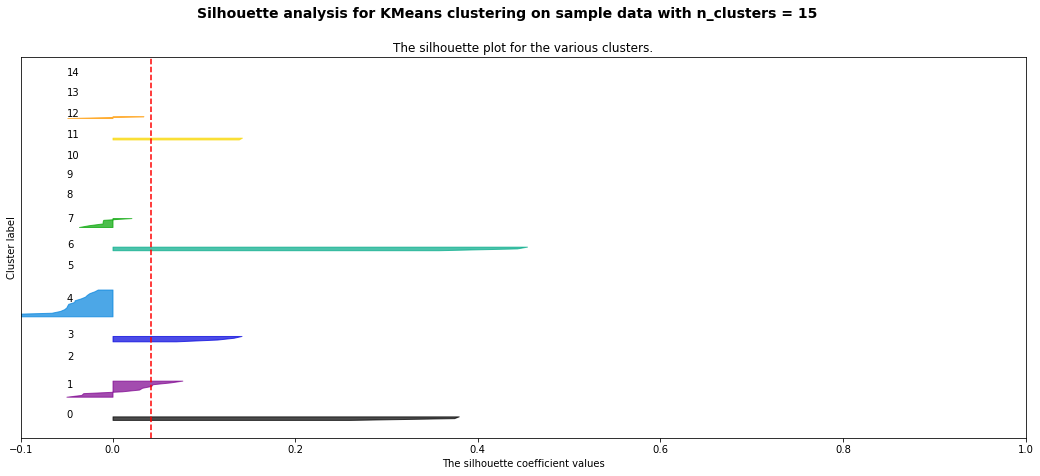

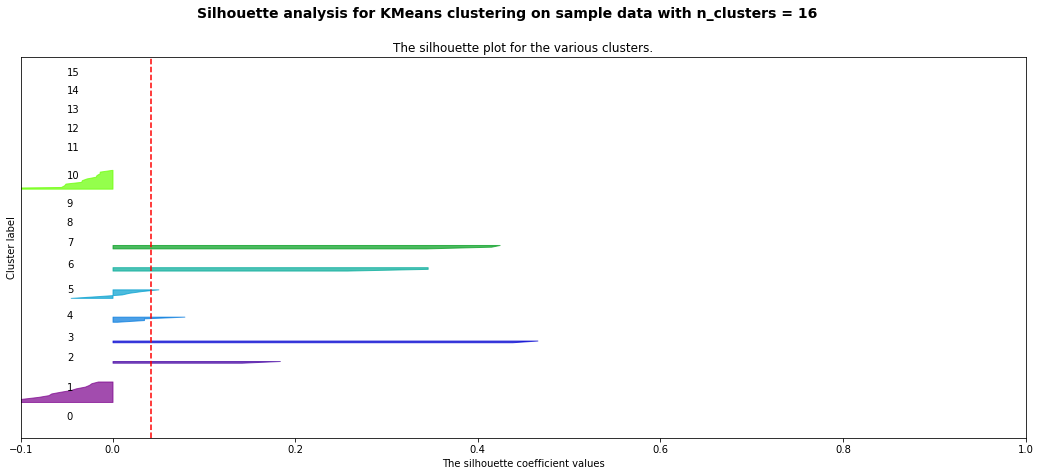

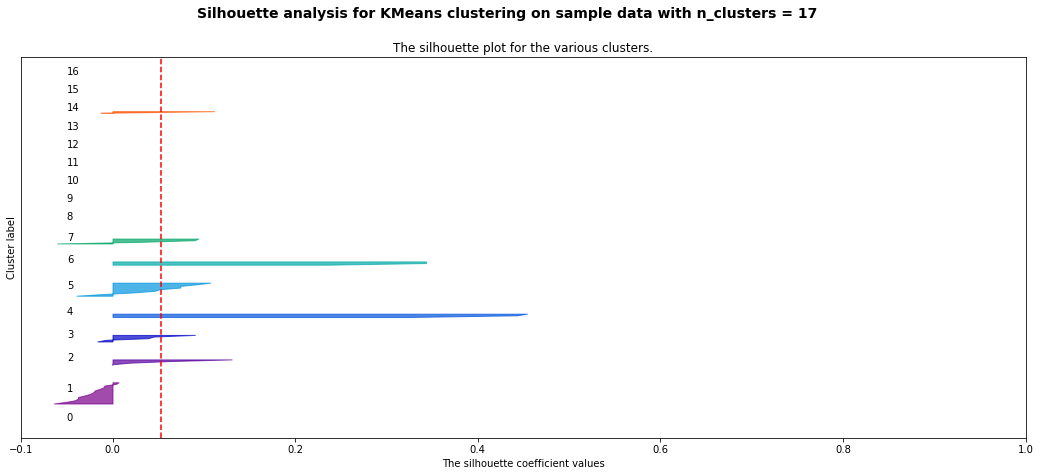

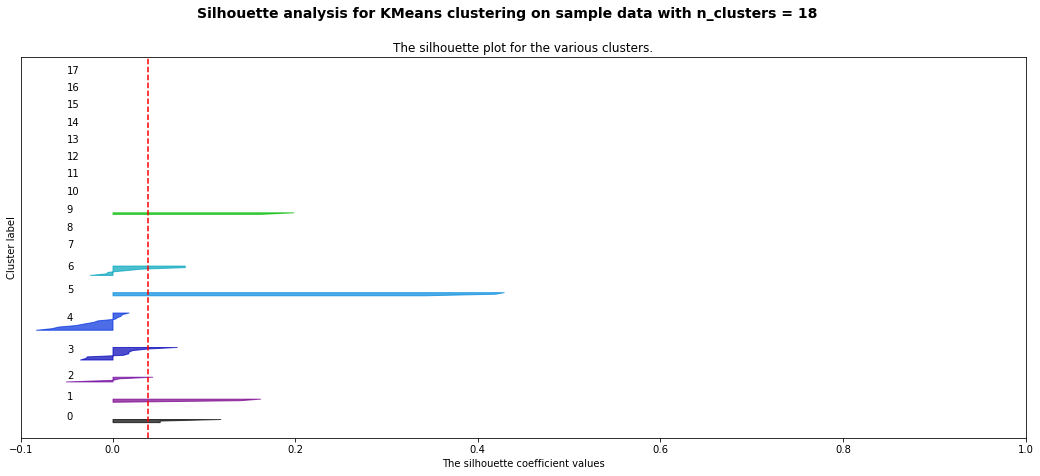

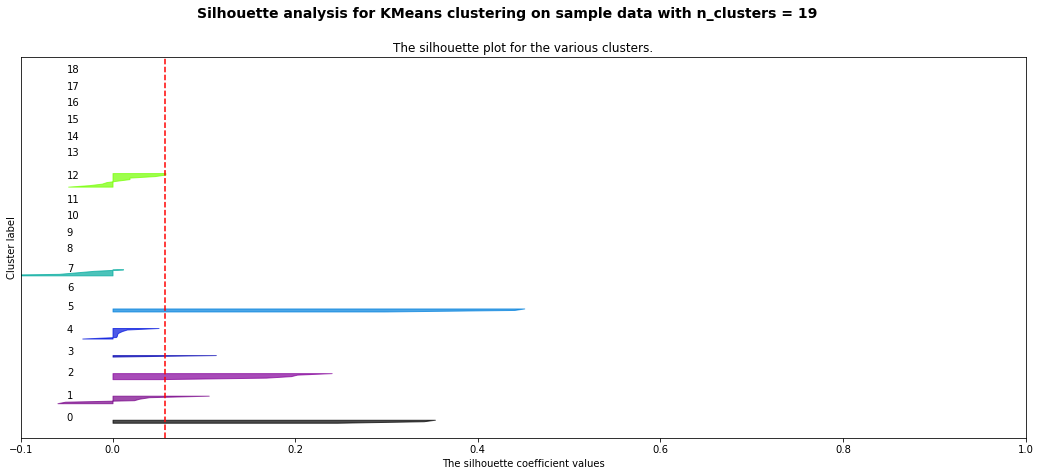

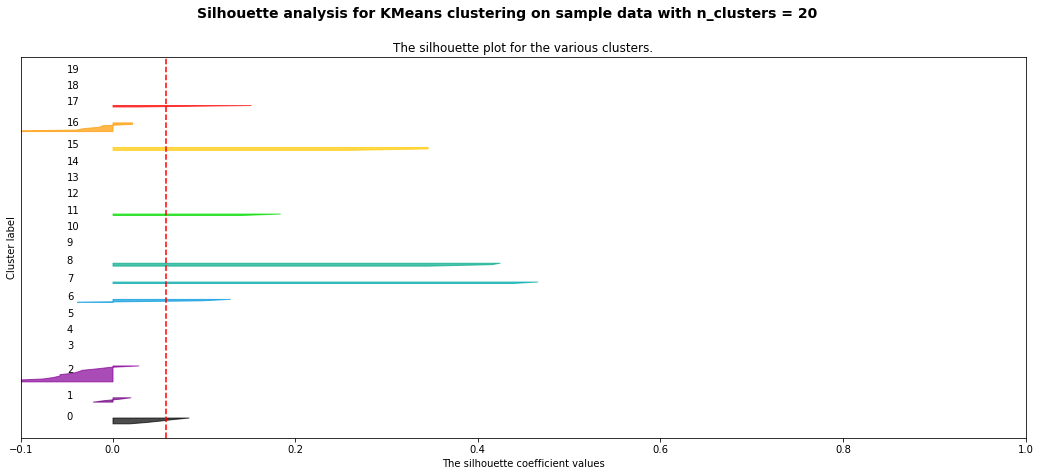

In [386]:
# def silhoutte_score_validation(model, transformer, array):

clusters = np.arange(2,21,1)

preprocessed_data = CountVectorizer().fit_transform(X)

preprocessed_data = preprocessed_data.todense()

for n_clusters in clusters:

    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    predictor = KMeans(n_clusters)
    cluster_labels = predictor.fit_predict(preprocessed_data)


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(preprocessed_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(preprocessed_data, cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        #cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % n_clusters),fontsize=14, fontweight='bold')

plt.show()

# Functions to generate scores

We will define a function that will calcualte Levenshtein and Eucladian distance for both job title and location. We will use different vectorization and stemming methods.

1) Create preprocesing and model pipeline - This will return pipeline

2) Model Fit - This will take pipeline from step 1 and generate return fitted model. 

3) Result DF - This funcction creates result datagrame which will be further used to analyze

4) Levenshtein and Eucladian Distance Calcualtion on resulted dataframe

5) FInal Model - This will use total score = 0.5 * Levenshtein + 0.5 * Eucladian

In [387]:
def create_pipeline(preprocessor,  model):
    preprocessing_pipeline = Pipeline([('preprocessor', preprocessor),
                            ('pca', TruncatedSVD(n_components = 2))
                                  ])
    
    model_pipeline = Pipeline([('preprocessor', preprocessing_pipeline),
                       ('clustering', model)                           
                       ])
    
    return model_pipeline



def model_fit(pipeline, X, string):
    pipeline.fit(X)
    preprocessed_data = pipeline['preprocessor'].transform(X)
    predicted_labels = pipeline['clustering'].labels_
    clusters = pipeline['clustering'].cluster_centers_
    keywords_transformed = pipeline['preprocessor'].transform([string])
    
    return preprocessed_data, predicted_labels, keywords_transformed
    
    

def create_results_df(X, preprocessing, predictions):
    # Save the points with the predictions
    df = pd.DataFrame(preprocessing, columns = ['x', 'y'])
    df['results'] = predictions
    df['full_string'] = X
    
    return df

def plot_scatter(df, keyword, title):
    # This will group based on the different labels
    sns.scatterplot(x = 'x', y = 'y', hue = 'results', data = df, palette = sns.color_palette("tab10", 
                                                            len(df['results'].unique())))
    # The keywords will be plotted in the space 
    plt.scatter(keyword[0][0], keyword[0][1], s = 70, marker = 'X', color = 'black')
    plt.legend(loc = (1.05,0.5))
    plt.title(title)
    return plt.show()

    
def levenshtein_distance(df, string, original_df):
    distances = []
    for i in df['full_string']:
        normalized_levenshtein = NormalizedLevenshtein()
        d = normalized_levenshtein.distance(s0 = i, s1 = string)
        distances.append(d)
    df['levenshtein_distance'] = distances
#     df = df.sort_values(by = 'levenshtein_distance', ascending = True)
    df['levenshtein_distance_fit'] = np.exp(-df['levenshtein_distance'])
    df['job_title'] = original_df['job_title'].values
    df['location'] = original_df['location'].values
    df = df.reset_index(drop = True)
    return df

def euclidean_distance(df, keyword):
    #Euclidean distance use the pythagoras theorem to calculate the distance between two coordenates
    distance = [np.sqrt(((
                    df.iloc[i][0] - keyword[0][0]) ** 2) 
                        + ((df.iloc[i][1] - keyword[0][1]) ** 2)) for i in range(0, len(df))]
    # Save the euclidean distance in a column
    df['euclidean_distance'] = distance
    # Sort the values in ascending order (lower euclidean distance means higher fit)
#     df = df.sort_values(by = 'euclidean_distance', ascending = True)
    # Use softmax action with the exponential distance to calculate probabilities.
    df['euclidean_fit'] = np.exp(-df['euclidean_distance'])
    df = df.reset_index(drop = True)
    return df

def final_fit(df):
    df['final_fit_model'] = (df['levenshtein_distance_fit']*0.5) + (
                                        0.5 * df['euclidean_fit'])
#     df['job_title'] = original_df['job_title'].values
#     df = df.sort_values(by = 'final_fit_model', ascending = False)
    df = df.reset_index(drop = True)
    return df


def create_nlp_model(X, string, preprocessor, model, original_df):
    pipe = create_pipeline(preprocessor,  model)
    preprocessed_data, predicted_labels, keywords_transformed = model_fit(pipe, X, string)
    result_df = create_results_df(X, preprocessed_data, predicted_labels)
    plot_scatter(df = result_df, keyword = keywords_transformed, title = 'KMeans Clusters CV')
    plt.show()
    result_df = levenshtein_distance(result_df, string, original_df)
    result_df = euclidean_distance(result_df, keywords_transformed)
    result_df = final_fit(result_df)
    return result_df

# Creating Keywords

In [388]:
# X = df_clean['full_string'].values
keyword_job = 'Aspiring Human Professional'
keyword_job_processed = ' '.join(get_unigram(keyword_job))
keyword_location = 'California'
keyword_location_processed = ' '.join(get_unigram(keyword_location))

# Model 1 : Stemming + Count Vectorizer

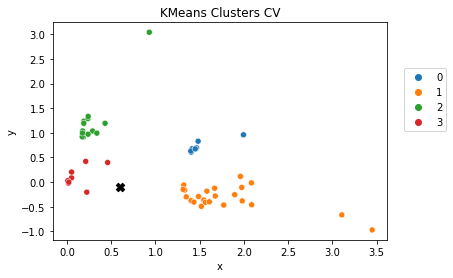

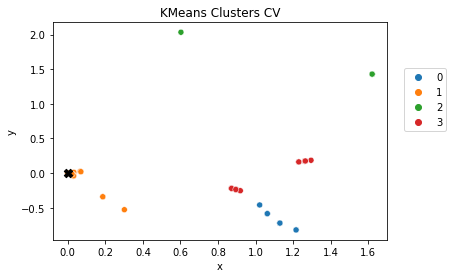

In [389]:
cv_df_job = create_nlp_model(X_job, keyword_job_processed, CountVectorizer(), KMeans(4), df_clean)
cv_df_location = create_nlp_model(X_location, keyword_location_processed, CountVectorizer(), KMeans(4), df_clean)

In [390]:
def final_result (df1, df2, weights):
    assert(np.sum(weights) == 1.0)
    
    df = pd.DataFrame()
    df['job_title'] = df1['job_title'].values
    df['location'] = df1['location'].values
    
    df['levenshtein_distance_job'] = df1['levenshtein_distance']
    df['levenshtein_fit_job'] = df1['levenshtein_distance_fit']
    df['euclidean_distance_job'] = df1['euclidean_distance']
    df['euclidean_fit_job'] = df1['euclidean_fit']
    
    
    df['levenshtein_distance_location'] = df2['levenshtein_distance']
    df['levenshtein_fit_location'] = df2['levenshtein_distance_fit']
    df['euclidean_distance_location'] = df2['euclidean_distance']
    df['euclidean_fit_location'] = df2['euclidean_fit']
    
    
    df['final_fit'] = weights[0]*df['levenshtein_fit_job'] + \
                      weights[1]*df['euclidean_fit_job'] +\
                      weights[2]*df['levenshtein_fit_location'] +\
                      weights[3]*df['euclidean_fit_location'] 
        
        
    return df   
        
        
        
        
        
        
    

In [395]:
final_df = final_result (cv_df_job, cv_df_location, [0.35,0.35,0.15,0.15])

In [396]:
final_df.sort_values(by = 'final_fit', ascending = False).head()

,job_title,location,levenshtein_distance_job,levenshtein_fit_job,euclidean_distance_job,euclidean_fit_job,levenshtein_distance_location,levenshtein_fit_location,euclidean_distance_location,euclidean_fit_location,final_fit
40,seeking employment opportunities within custom...,torrance california,0.819444,0.440676,0.384901,0.680518,0.473684,0.622704,0.000216,0.999784,0.635791
36,human resources management major,milpitas california,0.781250,0.457833,0.717224,0.488105,0.473684,0.622704,0.000216,0.999784,0.574452
34,information systems specialist and programmer ...,gaithersburg maryland,0.831325,0.435472,0.524449,0.591881,0.857143,0.424373,0.004725,0.995286,0.572522
35,bachelor of science in biology from victoria u...,baltimore maryland,0.797101,0.450633,0.653999,0.519962,0.666667,0.513417,0.004725,0.995286,0.566014
13,seeking human resources opportunities,chicago illinois,0.648649,0.522752,0.848662,0.427987,0.687500,0.502832,0.032002,0.968505,0.553459


Above method using stemming and Count vectorizer. We can see that top results are within california location. However, it does not give job title we want. 

# Model 2 : Stemming + TfIdf Vectorizer

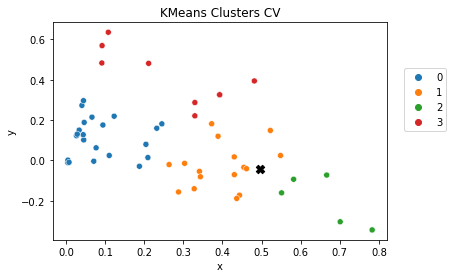

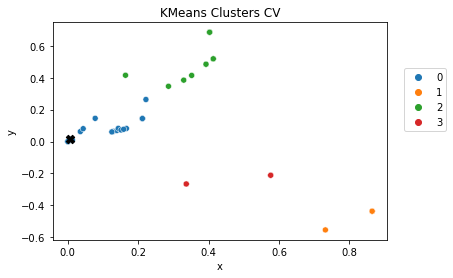

In [397]:
# tf_df = create_nlp_model(X, keyword_processed, TfidfVectorizer(), KMeans(4), df_clean)

tf_df_job = create_nlp_model(X_job, keyword_job_processed, TfidfVectorizer(), KMeans(4), df_clean)
tf_df_location = create_nlp_model(X_location, keyword_location_processed, TfidfVectorizer(), KMeans(4), df_clean)

In [399]:
final_df = final_result (tf_df_job, tf_df_location, [0.25,0.25,0.25,0.25])

In [400]:
final_df.sort_values(by = 'final_fit', ascending = False).head()

,job_title,location,levenshtein_distance_job,levenshtein_fit_job,euclidean_distance_job,euclidean_fit_job,levenshtein_distance_location,levenshtein_fit_location,euclidean_distance_location,euclidean_fit_location,final_fit
36,human resources management major,milpitas california,0.781250,0.457833,0.089673,0.914230,0.473684,0.622704,0.005865,0.994152,0.747230
13,seeking human resources opportunities,chicago illinois,0.648649,0.522752,0.042536,0.958356,0.687500,0.502832,0.055134,0.946358,0.732574
47,seeking human resources position,las vegas nevada area,0.531250,0.587870,0.034825,0.965774,0.857143,0.424373,0.127304,0.880466,0.714621
32,human resources professional for the world lea...,highland california,0.800000,0.449329,0.237343,0.788721,0.473684,0.622704,0.005842,0.994175,0.713732
48,aspiring human resources manager graduating m...,cape girardeau missouri,0.824561,0.438427,0.071358,0.931128,0.782609,0.457212,0.017057,0.983087,0.702464


As we can see from above results tfidf along with stemming performed better compared to count vectorizer. However, still it does not do well interms of location. But however, it apears top result is perfect match. 

# Lemmatization

Now we will use same approach but we will use Lemmatization instead of stemming. This will help to maintain context of word. We will create another dataframe where we apply lemmatization.

In [401]:
df_clean2 = df.drop_duplicates()
df_clean2.head()

,job_title,location,connection
0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85
1,Native English Teacher at EPIK (English Progra...,Kanada,500+
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44
3,People Development Coordinator at Ryan,"Denton, Texas",500+
4,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+


In [402]:
df_clean2['job_title'] = [cleaning(s) for s in df_clean2['job_title']]
df_clean2['location'] = [cleaning(s) for s in df_clean2['location']]
df_clean2['location'] = df_clean2['location'].replace(to_replace = ['kanada', 'türkiye', 'amerika birleşik devletleri'], 
                                            value = ['canada', 'turkey', 'united states america'], 
                                            regex = True)

df_clean2['connection'] = df_clean2['connection'].replace(to_replace = '500', value = 500, regex = True)
df_clean2['full_string'] = df_clean2.apply(lambda x : x['job_title'] +' ' + x['location'], axis = 1)

Here get_unigram function lemmatize each word in job title and location.

In [403]:
def get_unigram(question):
    doc = nlp(question)
    word_list =  [word.lemma_ for word in doc]
    return  [word for word in word_list if word not in stop_words]


df_clean2['unigram_full_string'] = df_clean2['full_string'].apply(lambda x : list(set(get_unigram(str(x)))))
# df_clean2['unigram_location'] = df_clean2['location'].apply(lambda x : list(set(get_unigram(str(x)))))

In [404]:
df_clean2['full_string'] = df_clean2['unigram_full_string'].apply(lambda x : ' '.join(x))

In [405]:
df_clean2.head()

,job_title,location,connection,full_string,unigram_full_string
0,2019 ct bauer college of business graduate mag...,houston texas,85,magna business laude aspire professional houst...,"[magna, business, laude, aspire, professional,..."
1,native english teacher at epik english program...,canada,500,korea canada english epik program teacher native,"[korea, canada, english, epik, program, teache..."
2,aspiring human resources professional,raleigh-durham north carolina area,44,north carolina professional aspire resource hu...,"[north, carolina, professional, aspire, resour..."
3,people development coordinator at ryan,denton texas,500,development coordinator ryan people denton texas,"[development, coordinator, ryan, people, dento..."
4,advisory board member at celal bayar university,i̇zmir turkey,500,i̇zmir celal member bayar turkey board univers...,"[i̇zmir, celal, member, bayar, turkey, board, ..."


In [406]:
X = df_clean2['full_string'].values
X2 = ' '.join(X)
X2 = [X2]



In [407]:
# Get the word importance using all the document

df_word_importance2 = word_importance_doc(array = X2)

# Save the df as a transpose (in this particular case)

df_word_importance2_transponse = df_word_importance2.T

# Check Out the word imortance

word_importance = df_word_importance2_transponse.nlargest(n = 10, columns = df_word_importance2_transponse.columns[0])

word_importance.columns = ['Importance']

In [408]:

word_importance

,Importance
human,0.493536
resource,0.493536
area,0.447267
aspire,0.200499
great,0.169653
professional,0.154230
seek,0.154230
texas,0.138807
california,0.107961
manager,0.107961


# Models

We will first crate two features. X_job and X_location. 

In [346]:
X_job = df_clean2['job_title'].values
X_location = df_clean2['location'].values

## Kmeans Clusters

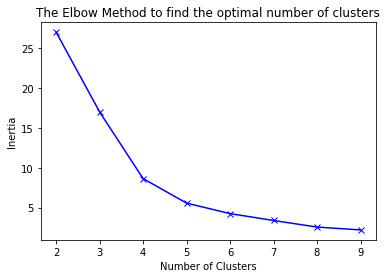

In [347]:
clusters = np.arange(2,10,1)
distortions = []

for c in clusters:
    Kmeans_pipeline = Pipeline([('vectorizer', CountVectorizer()),
                                ('pca', TruncatedSVD(n_components = 2)),
                           ('clustering', KMeans(c))                           
                           ])
    Kmeans_pipeline.fit(X)
    distortions.append(Kmeans_pipeline['clustering'].inertia_)
    
plt.plot(clusters, distortions, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method to find the optimal number of clusters')
plt.xticks(clusters)
plt.show()   

For n_clusters = 2 The average silhouette_score is : 0.083235481275804
For n_clusters = 3 The average silhouette_score is : 0.07900455064749395
For n_clusters = 4 The average silhouette_score is : 0.057305098680476445
For n_clusters = 5 The average silhouette_score is : 0.009998956076007117
For n_clusters = 6 The average silhouette_score is : 0.03355148202432547
For n_clusters = 7 The average silhouette_score is : 0.0290947073883088
For n_clusters = 8 The average silhouette_score is : 0.016702148986479527
For n_clusters = 9 The average silhouette_score is : 0.04425117483909087
For n_clusters = 10 The average silhouette_score is : 0.033053689689041585
For n_clusters = 11 The average silhouette_score is : 0.042589058642315956
For n_clusters = 12 The average silhouette_score is : 0.04631413129003844
For n_clusters = 13 The average silhouette_score is : 0.05097375206160072
For n_clusters = 14 The average silhouette_score is : 0.04348940452311349
For n_clusters = 15 The average silhouette_s

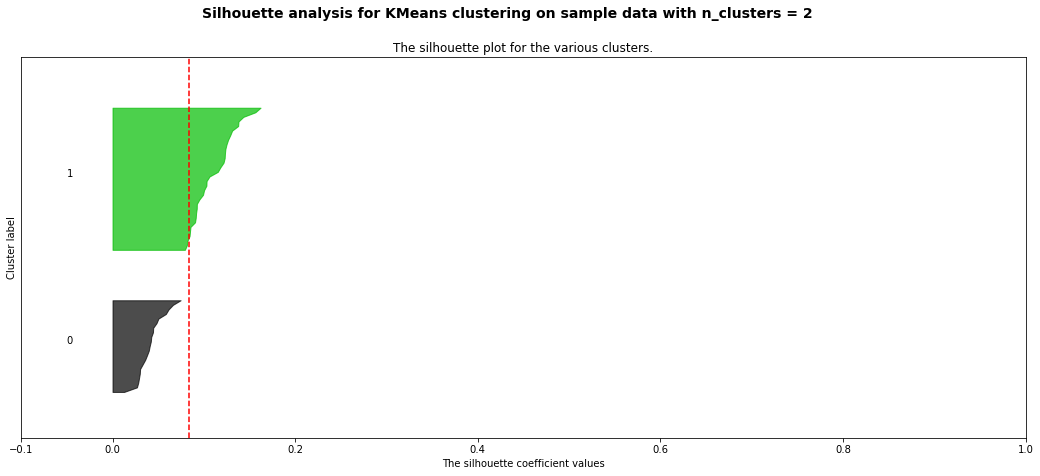

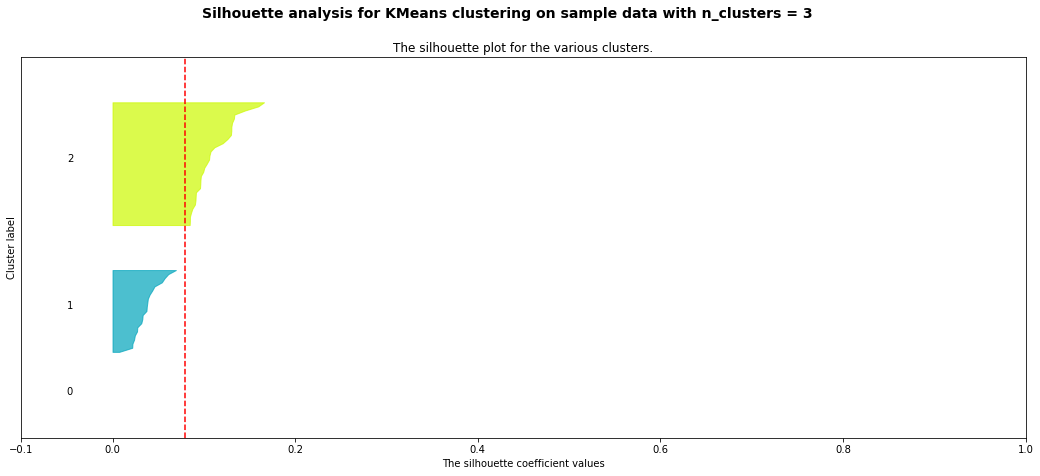

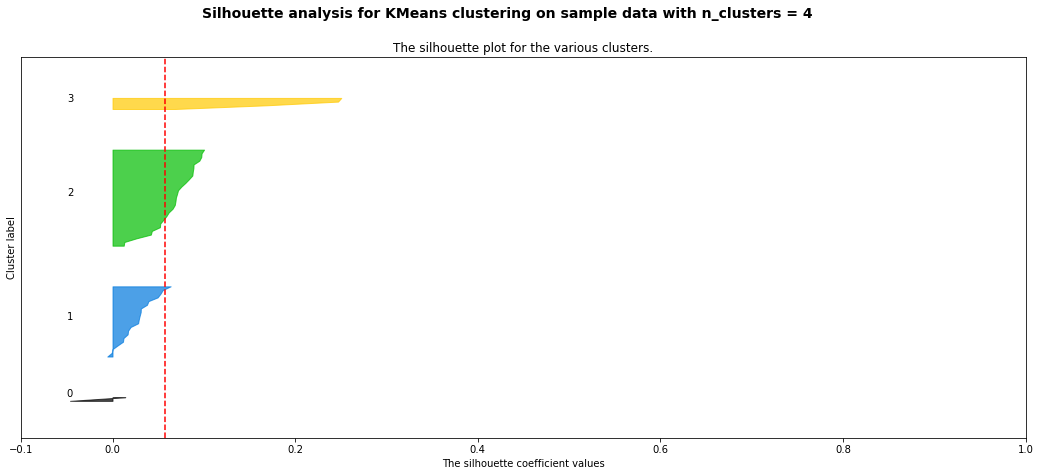

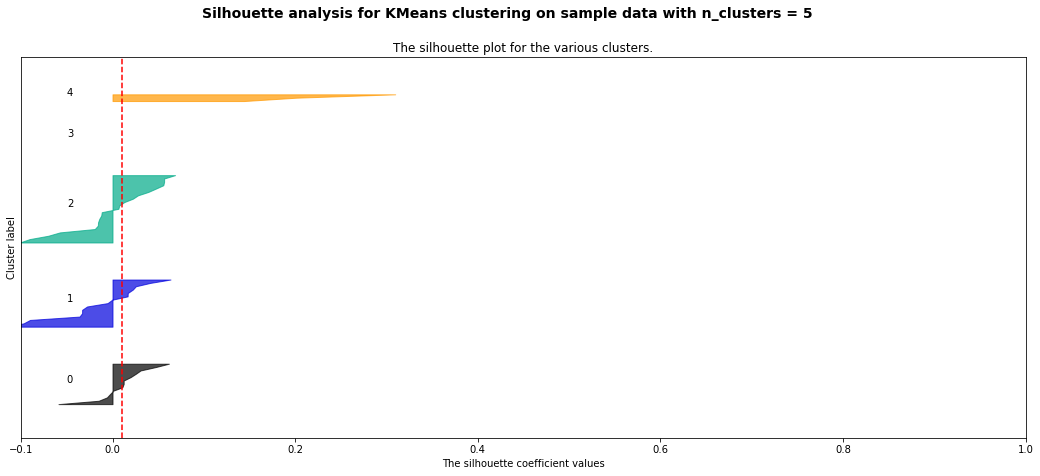

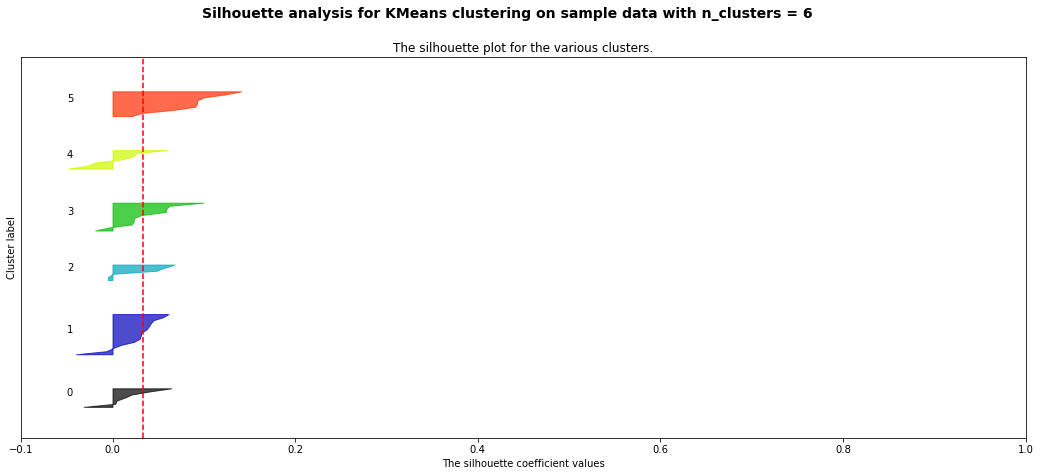

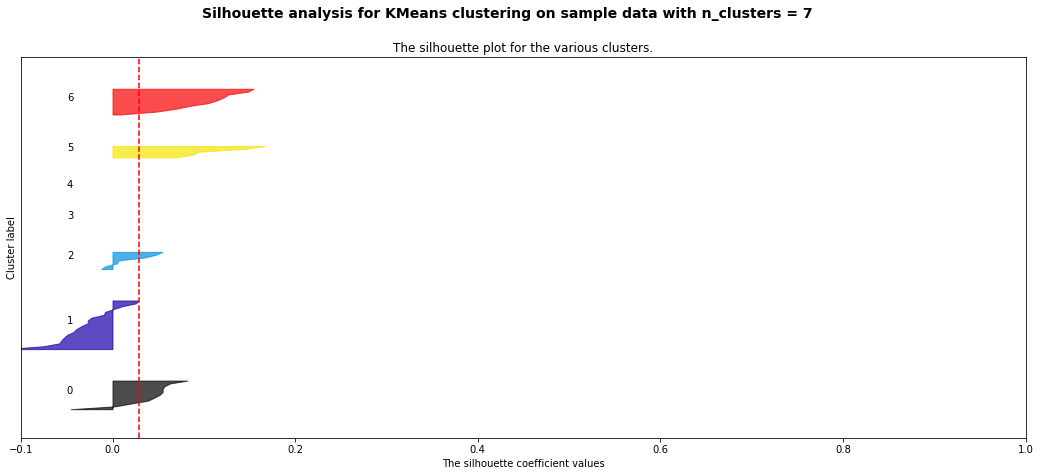

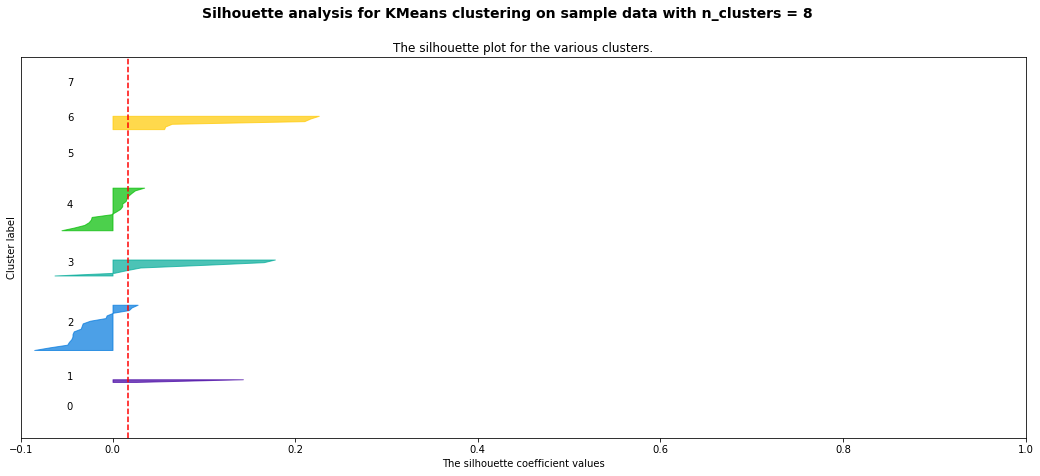

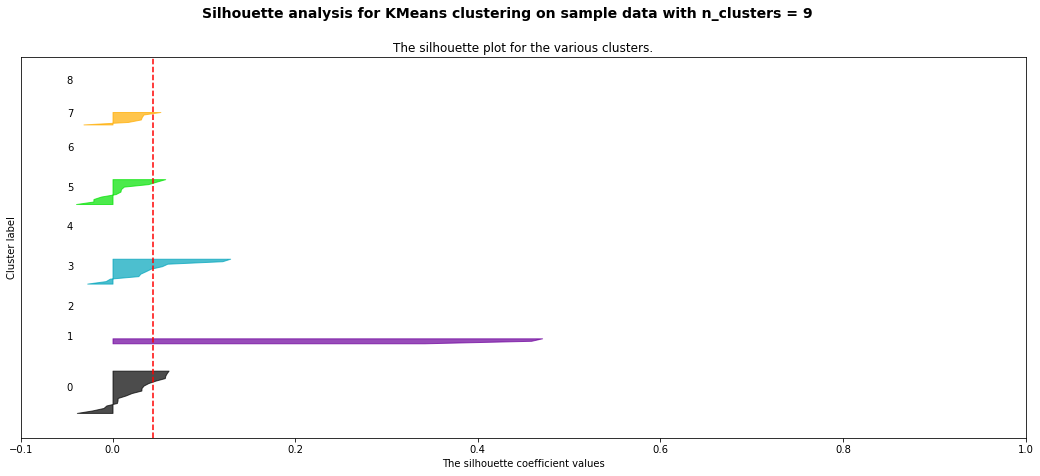

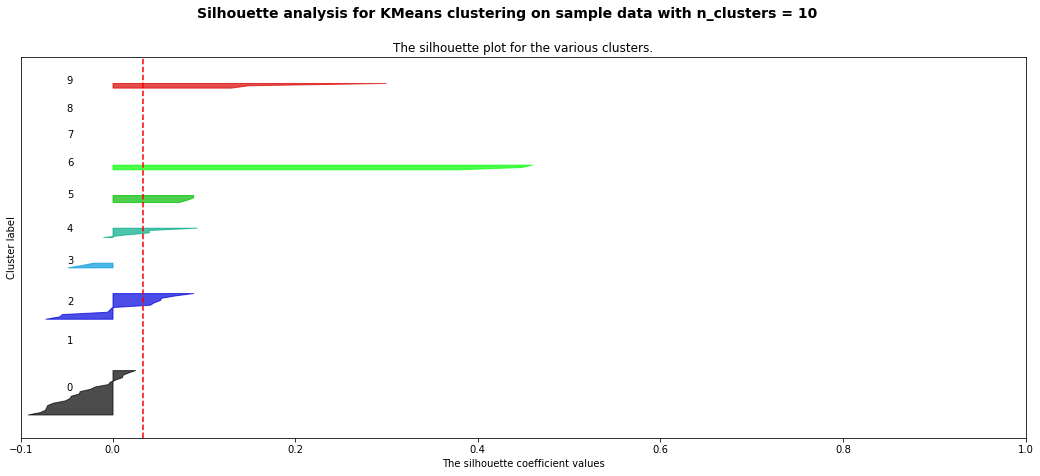

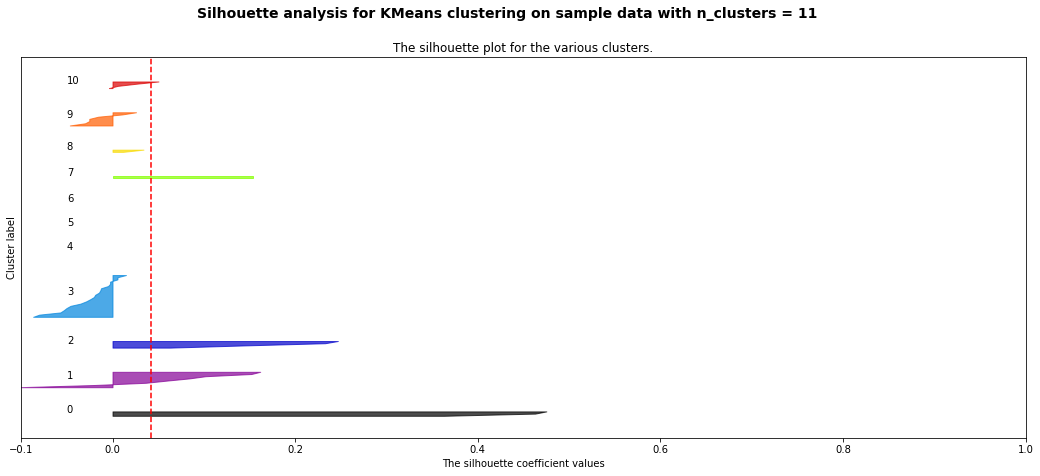

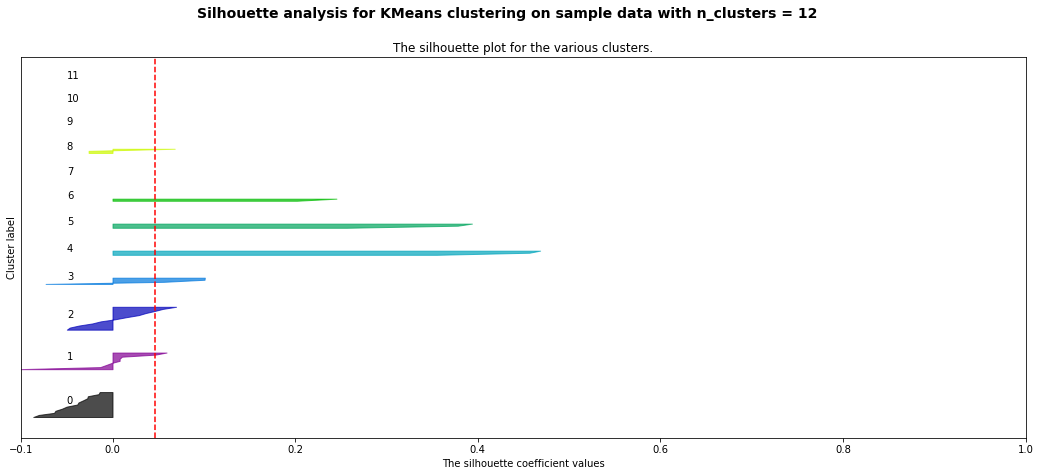

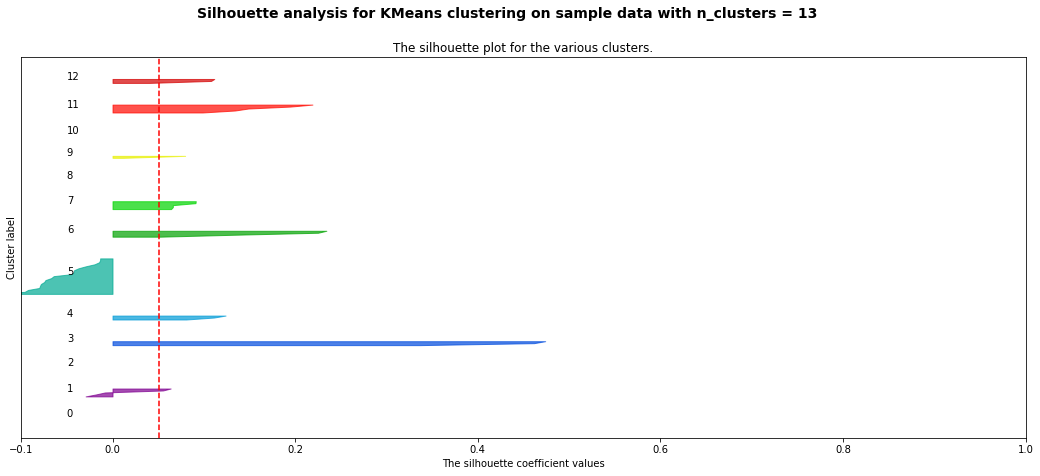

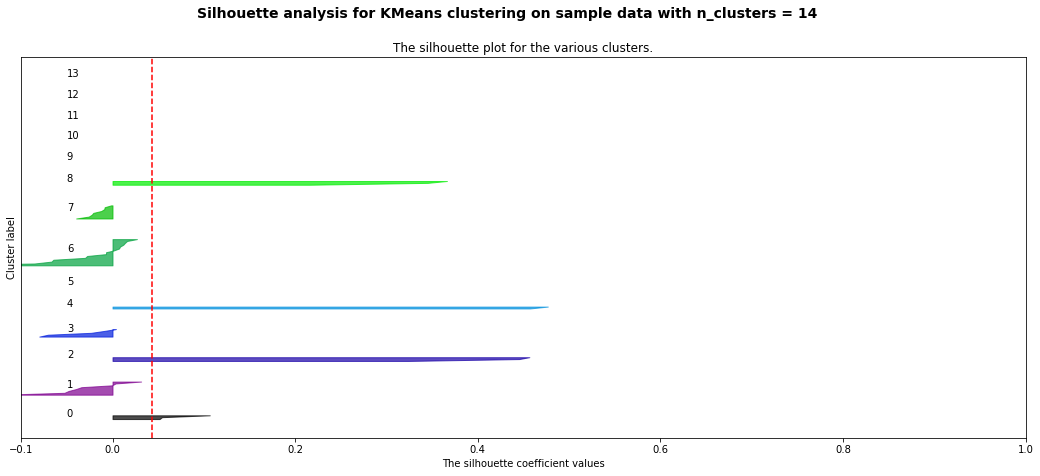

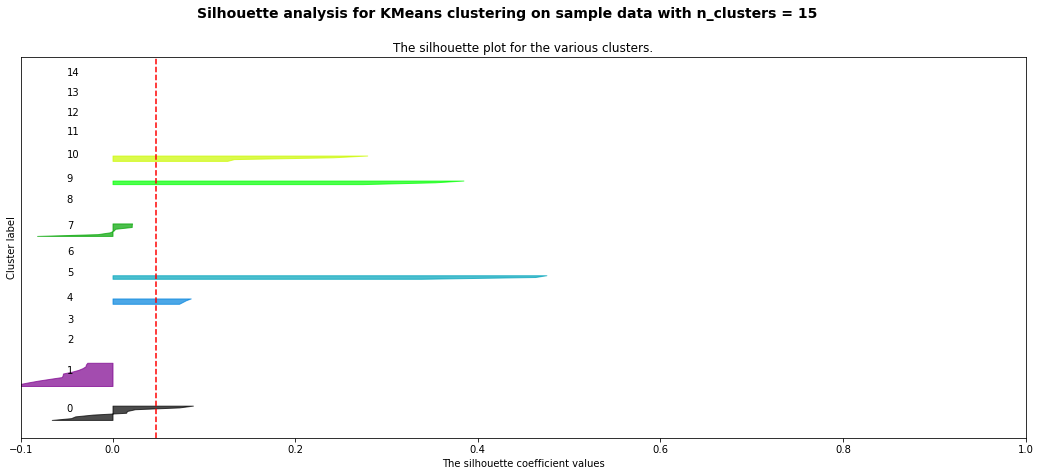

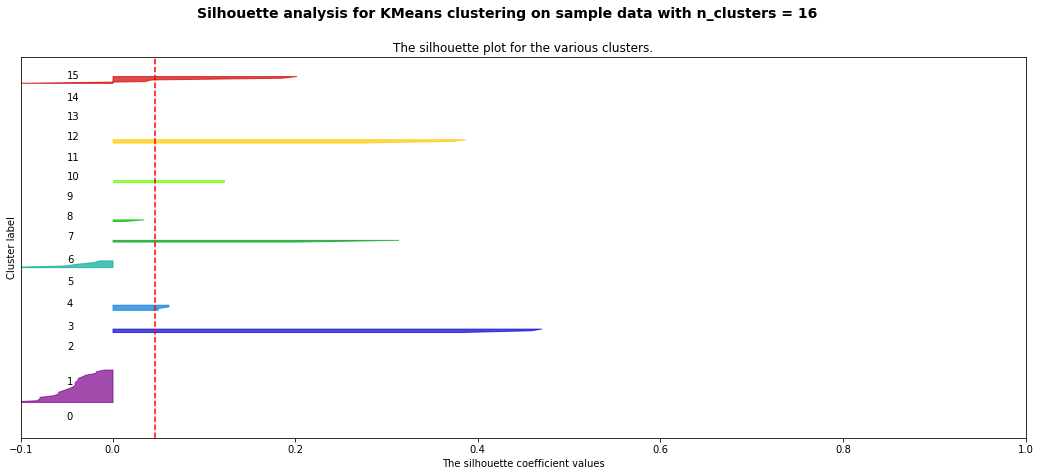

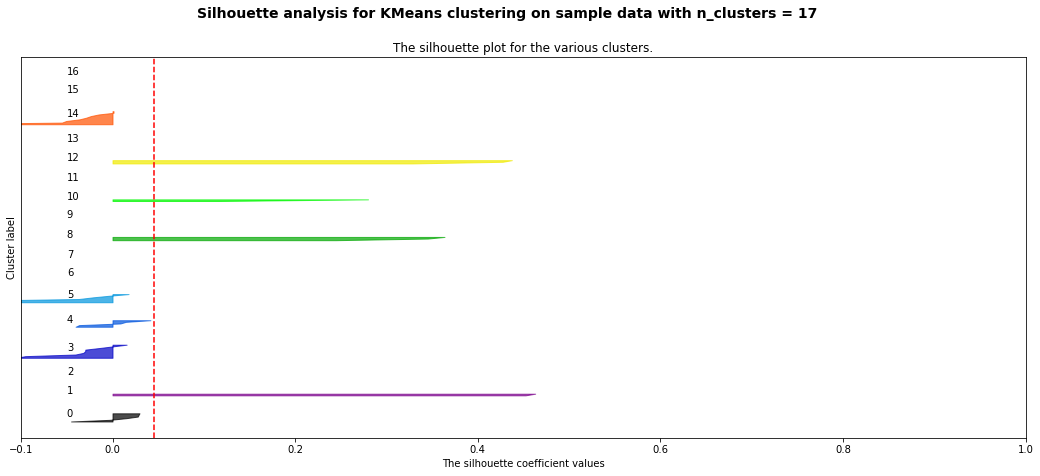

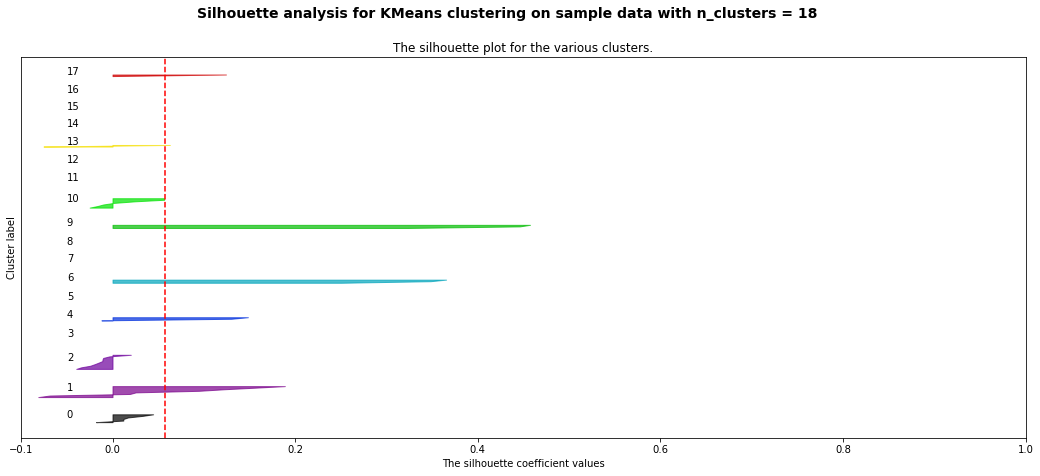

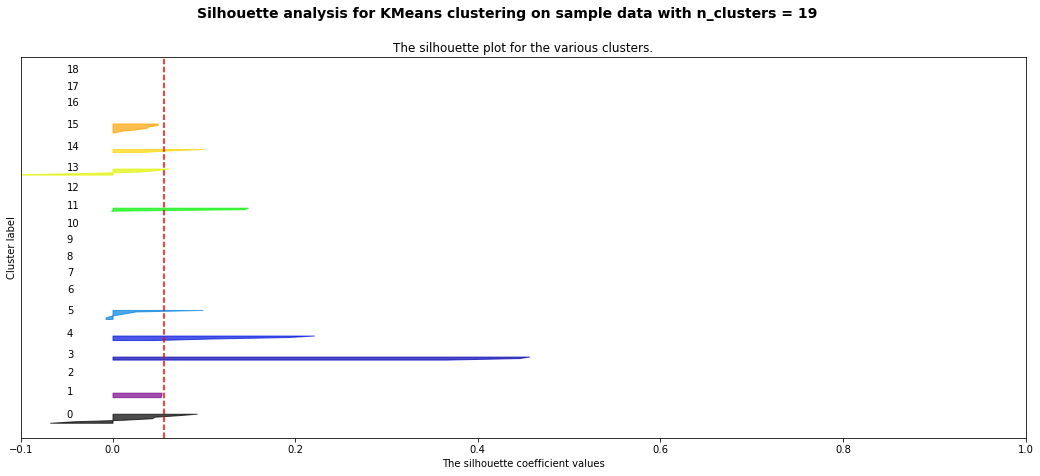

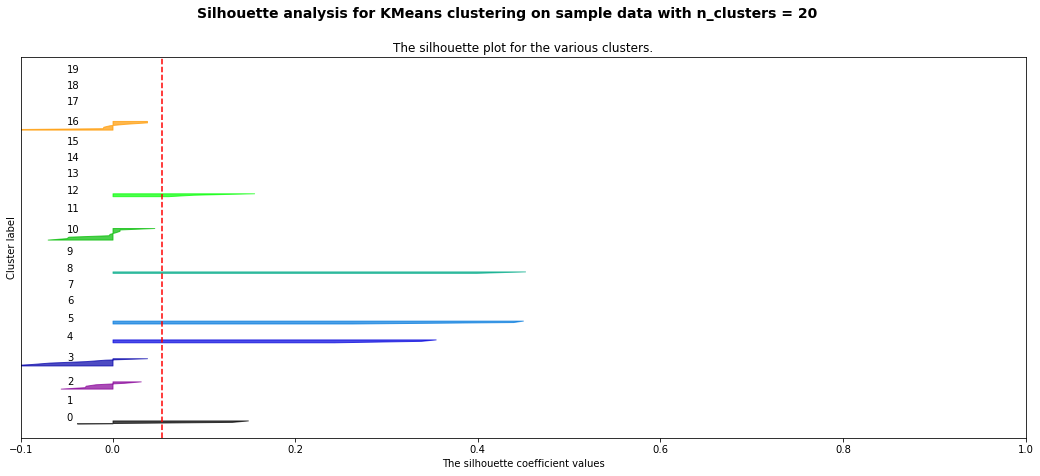

In [343]:
# def silhoutte_score_validation(model, transformer, array):

clusters = np.arange(2,21,1)

preprocessed_data = CountVectorizer().fit_transform(X)

preprocessed_data = preprocessed_data.todense()

for n_clusters in clusters:

    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    predictor = KMeans(n_clusters)
    cluster_labels = predictor.fit_predict(preprocessed_data)


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(preprocessed_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(preprocessed_data, cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        #cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
              "with n_clusters = %d" % n_clusters),fontsize=14, fontweight='bold')

plt.show()

##  Creating Keywords

In [409]:
# X = df_clean['full_string'].values
keyword_job = 'Aspiring Human Professional'
keyword_job_processed = ' '.join(get_unigram(keyword_job))
keyword_location = 'California'
keyword_location_processed = ' '.join(get_unigram(keyword_location))

In [410]:
keyword_job_processed

'Aspiring Human Professional'

# Model 3 : Lemmatization  + Count Vectorizer

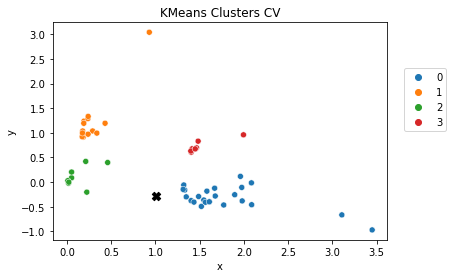

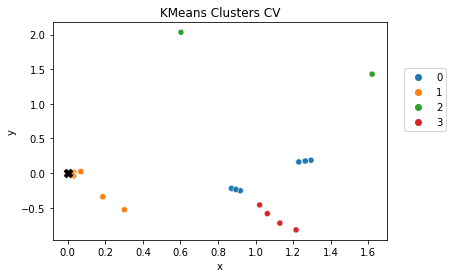

In [411]:
cv_df_job = create_nlp_model(X_job, keyword_job_processed, CountVectorizer(), KMeans(4), df_clean2)
cv_df_location = create_nlp_model(X_location, keyword_location_processed, CountVectorizer(), KMeans(4), df_clean2)

In [412]:
cv_df_job.sort_values(by = 'final_fit_model').head(5)

,x,y,results,full_string,levenshtein_distance,levenshtein_distance_fit,job_title,location,euclidean_distance,euclidean_fit,final_fit_model
44,0.930596,3.039925,1,student at indiana university kokomo - busines...,0.866667,0.420350,student at indiana university kokomo - busines...,lafayette indiana,3.331770,0.035730,0.228040
48,3.449334,-0.968811,0,aspiring human resources manager graduating m...,0.807018,0.446187,aspiring human resources manager graduating m...,cape girardeau missouri,2.530064,0.079654,0.262920
43,0.239556,1.332739,1,student at westfield state university,0.864865,0.421108,student at westfield state university,bridgewater massachusetts,1.797891,0.165648,0.293378
21,3.106647,-0.663954,0,aspiring human resources manager seeking inter...,0.714286,0.489542,aspiring human resources manager seeking inter...,houston texas area,2.127818,0.119097,0.304319
4,0.192175,1.237413,1,advisory board member at celal bayar university,0.829787,0.436142,advisory board member at celal bayar university,i̇zmir turkey,1.734180,0.176545,0.306344


In [413]:
def final_result (df1, df2, weights):
    assert(np.sum(weights) == 1.0)
    
    df = pd.DataFrame()
    df['job_title'] = df1['job_title'].values
    df['location'] = df1['location'].values
    
    df['levenshtein_distance_job'] = df1['levenshtein_distance']
    df['levenshtein_fit_job'] = df1['levenshtein_distance_fit']
    df['euclidean_distance_job'] = df1['euclidean_distance']
    df['euclidean_fit_job'] = df1['euclidean_fit']
    
    
    df['levenshtein_distance_location'] = df2['levenshtein_distance']
    df['levenshtein_fit_location'] = df2['levenshtein_distance_fit']
    df['euclidean_distance_location'] = df2['euclidean_distance']
    df['euclidean_fit_location'] = df2['euclidean_fit']
    
    
    df['final_fit'] = weights[0]*df['levenshtein_fit_job'] + \
                      weights[1]*df['euclidean_fit_job'] +\
                      weights[2]*df['levenshtein_fit_location'] +\
                      weights[3]*df['euclidean_fit_location'] 
        
        
    return df   
        
        
        
        
        
        
    

In [414]:
final_df = final_result (cv_df_job, cv_df_location, [0.25,0.25,0.25,0.25])

In [415]:
final_df.sort_values(by = 'final_fit', ascending = False).head()

,job_title,location,levenshtein_distance_job,levenshtein_fit_job,euclidean_distance_job,euclidean_fit_job,levenshtein_distance_location,levenshtein_fit_location,euclidean_distance_location,euclidean_fit_location,final_fit
36,human resources management major,milpitas california,0.875000,0.416862,0.334020,0.716039,0.526316,0.590778,0.000219,0.999781,0.680865
13,seeking human resources opportunities,chicago illinois,0.621622,0.537073,0.399668,0.670543,0.750000,0.472367,0.031975,0.968531,0.662128
32,human resources professional for the world lea...,highland california,0.800000,0.449329,0.564974,0.568375,0.526316,0.590778,0.000219,0.999781,0.652065
23,nortia staffing is seeking human resources pay...,san jose california,0.768421,0.463745,0.545397,0.579612,0.526316,0.590778,0.029025,0.971392,0.651381
40,seeking employment opportunities within custom...,torrance california,0.791667,0.453089,0.792659,0.452640,0.526316,0.590778,0.000219,0.999781,0.624072


We can see that Lemmatization performs much better comapred to stemmering. Also top 5 reesults are mots relevent. 

# Model 4 : Lemmatization + tfIdf Vectorizer

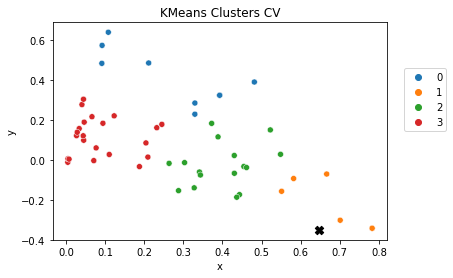

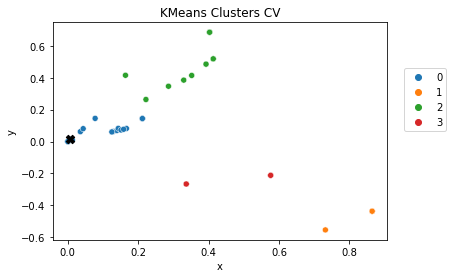

In [417]:
# tf_df = create_nlp_model(X, keyword_processed, TfidfVectorizer(), KMeans(4), df_clean)

tf_df_job = create_nlp_model(X_job, keyword_job_processed, TfidfVectorizer(), KMeans(4), df_clean2)
tf_df_location = create_nlp_model(X_location, keyword_location_processed, TfidfVectorizer(), KMeans(4), df_clean2)

In [418]:
tf_df_location.sort_values(by = 'final_fit_model', ascending = False)[['job_title','location',  'final_fit_model']].head(10)

,job_title,location,final_fit_model
23,nortia staffing is seeking human resources pay...,san jose california,0.792906
36,human resources management major,milpitas california,0.792502
40,seeking employment opportunities within custom...,torrance california,0.792499
32,human resources professional for the world lea...,highland california,0.792491
41,admissions representative at community medical...,long beach california,0.780249
9,student at chapman university,lake forest california,0.772890
35,bachelor of science in biology from victoria u...,baltimore maryland,0.748425
31,hr manager at endemol shine north america,los angeles california,0.740726
44,student at indiana university kokomo - busines...,lafayette indiana,0.728081
18,retired army national guard recruiter office m...,virginia beach virginia,0.723193


In [419]:
final_df = final_result (tf_df_job, tf_df_location, [0.25,0.25,0.25,0.25])

In [420]:
final_df.sort_values(by = 'final_fit', ascending = False).head()

,job_title,location,levenshtein_distance_job,levenshtein_fit_job,euclidean_distance_job,euclidean_fit_job,levenshtein_distance_location,levenshtein_fit_location,euclidean_distance_location,euclidean_fit_location,final_fit
45,aspiring human resources professional,kokomo indiana area,0.351351,0.703736,0.135471,0.873304,0.789474,0.454084,0.164585,0.848245,0.719842
2,aspiring human resources professional,raleigh-durham north carolina area,0.351351,0.703736,0.135471,0.873304,0.794118,0.451980,0.242756,0.784463,0.703371
32,human resources professional for the world lea...,highland california,0.800000,0.449329,0.409812,0.663775,0.526316,0.590778,0.005812,0.994205,0.674522
36,human resources management major,milpitas california,0.875000,0.416862,0.431052,0.649825,0.526316,0.590778,0.005791,0.994226,0.662922
13,seeking human resources opportunities,chicago illinois,0.621622,0.537073,0.371261,0.689864,0.750000,0.472367,0.054868,0.946610,0.661478


Compared to count vectorizer , tfIdf vectorizer does not perform as good as we want.

# Conclusion

We ran 4 different approaches.

1) Stemmering + Count Vectorizer

2) Stemmering + TfIdf Vectorizer

3) Lemmatization + Count Vectorizer

4) Lemmatization + TfIdf Vectorizer

We can conclude that out of all methods,

**Lemmatization + Countvectorizer** performs better,